In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from adafilt import LMSFilter, SimpleFilter
from adafilt.utils import olafilt

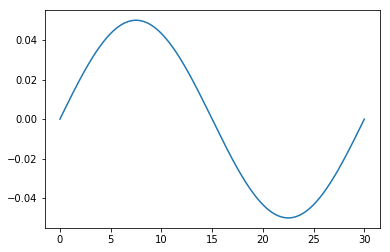

In [23]:
fs = 200
T = 30  # length of simulation
Nsim = fs * T
t = np.linspace(0, T, Nsim, endpoint=False)  # simulation time

# the system delay is sinussoidal and makes one periode
fdelay = 1/T
dt = np.sin(2 * np.pi * fdelay * t) * 0.05

plt.plot(t, dt);

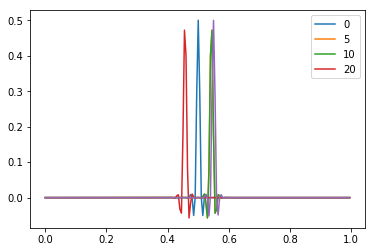

In [24]:
from scipy.signal import filtfilt, butter

# Model the time varing path
Tfilt = 1
Nfilt = Tfilt * fs
h = np.zeros(Nfilt)
h[Nfilt // 2] = 1
b, a = butter(2, 50, btype='lowpass', fs=fs)
h = filtfilt(b, a, h, axis=0)

omega = 2 * np.pi * np.linspace(0, fs / 2, Nfilt // 2 + 1)
H = np.fft.rfft(h)[:, None] * np.exp(-1j*omega[:, None] * dt)
h = np.fft.irfft(H, axis=0)

plt.figure()
t = np.linspace(0, Tfilt, Nfilt, endpoint=False)
plt.plot(t, h[:, np.array([0, 5, 10, 20]) * fs]);
plt.legend([0, 5, 10, 20]);

plt.plot(t, h[:, 1424])

In [25]:
filt = LMSFilter(Nfilt, stepsize=1)

# aggregate signals during simulation
elog = []
dlog = []
wslog = []
dhatlog = []
xlog = []
dthatlog = []

zi = np.zeros(Nfilt - 1)
for i in tqdm(range(Nsim)):

    # signal
    x = np.random.normal(0, 1)
    d, zi = olafilt(h[:, i], x, zi=zi)

    dhat = filt.filt(x)

    e = d + dhat

    filt.adapt(x, e)
    
    dthat = np.argmax(np.abs(filt.w)) / fs

    xlog.append(x)
    elog.append(e)
    wslog.append(filt.w)
    dlog.append(d)
    dhatlog.append(dhat)
    dthatlog.append(dthat)

100%|██████████| 6000/6000 [00:00<00:00, 6038.02it/s]


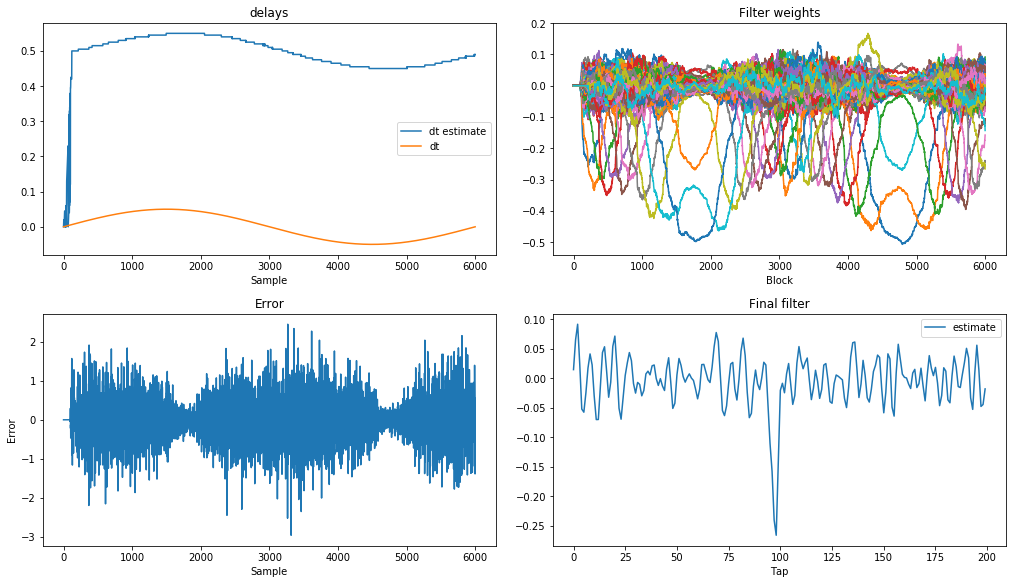

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 8), constrained_layout=True)

ax[0, 0].set_title("delays")
ax[0, 0].plot(dthatlog, label="dt estimate")
ax[0, 0].plot(dt, label="dt")
ax[0, 0].set_xlabel("Sample")
ax[0, 0].legend()

ax[0, 1].set_title("Filter weights")
ax[0, 1].plot(wslog)
ax[0, 1].set_xlabel("Block")

ax[1, 0].set_title("Error")
ax[1, 0].plot(elog)
ax[1, 0].set_xlabel("Sample")
ax[1, 0].set_ylabel("Error")

ax[1, 1].set_title("Final filter")
ax[1, 1].plot(filt.w, label="estimate")
ax[1, 1].set_xlabel("Tap")
ax[1, 1].legend();